The algorithm works like this:

![](https://mermaid.ink/svg/pako:eNqFVulu2zAMfhXCv1K03QPkx4b0WFFg64K2G7DZRaHYTCzElgxZTtfr3UcdPuQ4nYDWEimSH0_lNUplhtE82ihW5XB_kQigVTcrR_i5WMKi2EjFdV46nll3mik9m9nP0VFPvxZcc1bwF_wV93soeK1BrqFCpRu1YppLUcPuoRfsDF6hQMU0AodG8B2qmhWhXC9kLWp7PfZf0LmSzSaHusKUrzlmIJpyhYr0EYAMa66INq0aeMk2GAILvRo6FUhqFLVUsHvkwGpgXhU8UdjgBZXEeqSzc_iykmk-csqsr1JdsjSP6QtIGxCTWDnZzsltxbjgYgMZ06xG_bCvsLM4DpXTtC9g1hXqa8OOaWMNCfyrvXPG9P_NjsriHstqGEWnymcrDV3cPWq6_UEQ23WeY7qN7X_gayippAvgNaylLCjbq2cLPdQNx17_AZ1duH5Umpf8xYktlVwVWE6LmLWk8uKpjpPoO9uih1I5olFgnaF22nBB1cdE1sIinC4WM_c5tsXUgjxKoofDRs8Usm18i1qZgtdSUq1TRX75QOSbrOv4nBVpU7haoC4lksNnToMGkqq0SLkwTYNwdn75ERiWbislK7YxfRmcQIrekpawoaJK6UDtSSfDychobeK0ko3ImHr-wJDN94UXOPP3-yqYVAdP1J7K9BNmB1SjyKYZiyyL6Y_Qp-PB4SuVnDgwWSiXB8zdYoVM97BZUYBvrLbHc7ZDWCESwbVu1vbuhM5J-F2iByk3zWFa186C0XB2g4xSnraw2skZSPFDsdwDcUcuxIuqwr7ge0MUNvtCjOeujcnNcjj8-zi1gFhJqbWvy4H3giZ_Tkm38dtHGyDtd9RLjRKzmfvCrn3k7HW3tY8fnJ5-Ho43xxoQ3AWXNs_04zeUHAtatn8DHM8fLKMdy47TnsZgzKzdA2SI9qKNpGO7oBLx7TfWb6bQx_Qb-daONsfyB6vJzBJHNTtLCtre8cJJ0CEYN_DA8phlhaYgTl80mO1k9PbNtucE3njep06_60rHND1vxIY0t-9D1rXVmO2Mhfnqe7B3yDTIJNeIB3VgbvbhC9tjEJOQ0SUxKMVDF30ITOknIjqJSlQl4xn9THw1gklEs7XEJJrTluK9TaJEvNM91mh59yzSaK5VgydRU9HvArzgjF7SMpqvWVETtWLij5Tt-f0f7X5Wpw)

In [1]:
# %load_ext autoreload
# %autoreload 2

import os

os.chdir("..")
import torch
import torchvision
import matplotlib.pyplot as plt 
from src.utils.download import download_models
from src.utils.uap_helper import generate_adversarial_images_from_model_dataset, get_datamodule, get_model
from lightning.pytorch import loggers as pl_loggers

In [2]:
ENTITY = "24FS_I4DS27"
PROJECT = "baselines"
NUM_WORKERS = 8

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224), antialias=True),
    ]
)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [3]:
# Download models if not present
models = download_models(ENTITY, PROJECT)

In [23]:
modelname, dataset = "resnet18", "mri_data"
print(f"\n---\nModel: {modelname} - Dataset: {dataset}")

current_robustification = 0
n = 200

logger = pl_loggers.CSVLogger("test", name=f"{modelname}-{dataset}-n_{n}-robustification_{current_robustification}", version="UAPs_pre_robustification", flush_logs_every_n_steps=1)

model, hparams = get_model(modelname=modelname, dataset=dataset, output_size=1, return_hparams=True)
perturbations = generate_adversarial_images_from_model_dataset(
    model=model,
    modelname=modelname,
    dataset=dataset,
    logger=logger,
    transform=transform,
    i=5,
    n=n,
    r=0.2,
    p=2,
    lambda_norm=1,
    t=50,
    eps=1e-6,
    lr_uap=1,
    seed=42,
    verbose=False,
    num_workers=NUM_WORKERS,
    device=device,
)
logger.save()


---
Model: resnet18 - Dataset: mri_data


/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory test/resnet18-mri_data-n_200-robustification_0/UAPs_pre_robustification exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!


Universal Pertubation:   0%|          | 0/5 [00:00<?, ?it/s]

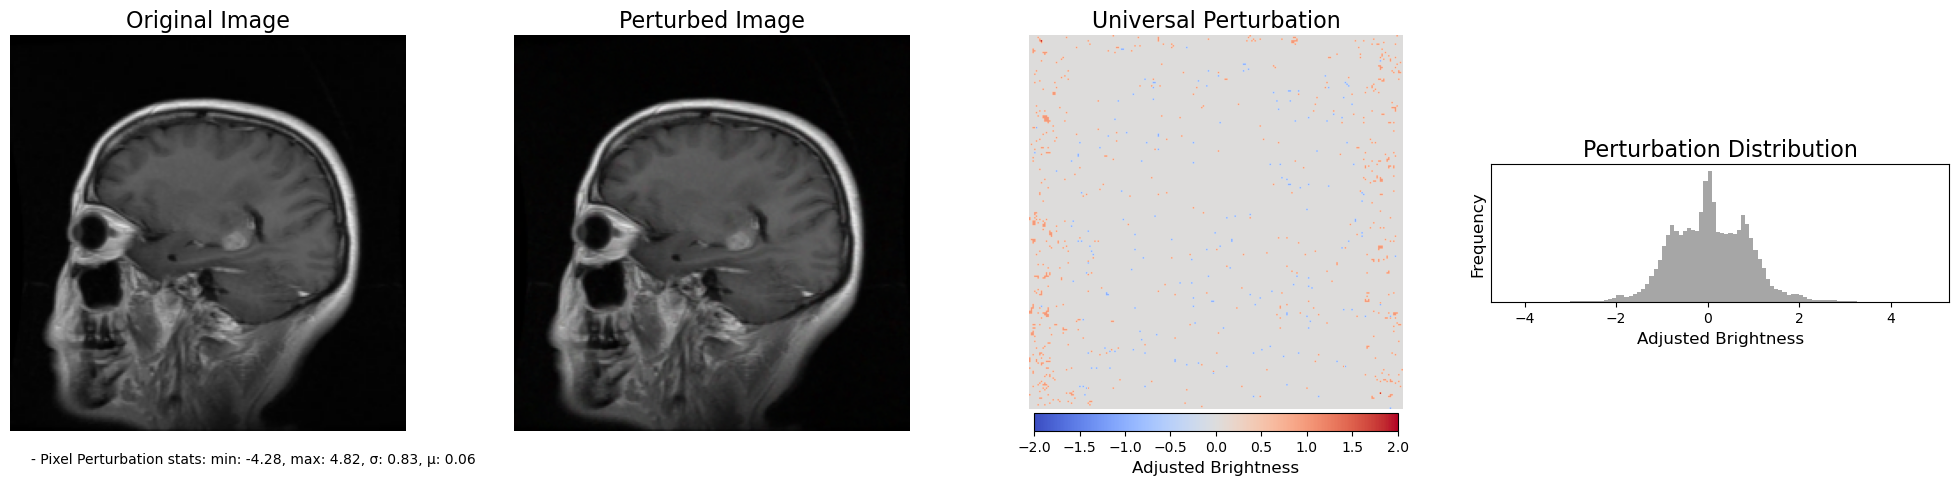

In [24]:
v = perturbations[0].detach()
get_datamodule(dataset, seed=42).setup()
image, _ = next(iter(get_datamodule(dataset).train_dataloader()))

# Prepare subplots in one row
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Original Image
axs[0].imshow(image.cpu().squeeze().permute(1, 2, 0).numpy().astype(int))
axs[0].set_title("Original Image", fontsize=16)
axs[0].axis("off")  # Hide axes for cleaner look

# Perturbed Image
x_adv = image + v.cpu()
x_adv = torch.clamp(x_adv, 0, 255)
axs[1].imshow(x_adv.cpu().squeeze().permute(1, 2, 0).numpy().astype(int))
axs[1].set_title("Perturbed Image", fontsize=16)
axs[1].axis("off")

# Perturbation Visualization
perturbation_visual = v.mean(dim=0).cpu().squeeze().numpy().astype(int)
vmax = abs(perturbation_visual).max()
im = axs[2].imshow(perturbation_visual, cmap="coolwarm", vmin=-vmax, vmax=vmax)
axs[2].set_title("Universal Perturbation", fontsize=16)
axs[2].axis("off")
cbar = plt.colorbar(im, ax=axs[2], fraction=0.046, pad=0.01, location="bottom")
cbar.set_label("Adjusted Brightness", fontsize=12)

# Statistical Distribution of Perturbation
axs[3].hist(v.cpu().flatten(), bins=100, color="grey", alpha=0.7)
axs[3].set_aspect(0.0003125, adjustable="box")
axs[3].set_title("Perturbation Distribution", fontsize=16)
axs[3].set_yticks([])
axs[3].axis("on")
axs[3].set_ylabel("Frequency", fontsize=12)
axs[3].set_xlabel("Adjusted Brightness", fontsize=12)

plt.suptitle(
    f"- Pixel Perturbation stats: min: {v.min().item():.2f}, max: {v.max().item():.2f}, σ: {v.std().item():.2f}, μ: {v.mean().item():.2f}",
    fontsize=10,
    y=0.075,
    x=0.145,
)

plt.tight_layout()
plt.show()